In [33]:
import pandas as pd
import numpy as np  
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.preprocess_mine import KlarnaDataProcessor
#from src.preprocess import KlarnaDataProcessor


# Load and process data

In [34]:
data_raw = pd.read_csv('../02-data/mlcasestudy.csv')

In [35]:
# preprocess.py
# # Initialize processor
data = KlarnaDataProcessor(data_raw)

# define target and clean data
data.define_target_variable_and_clean_data()

# perform feature engineering
data.feature_engineering()



Initialized KlarnaDataProcessor with 111,902 rows and 24 columns
Default rate: 0.054 (5.4%)
Defaults: 6,089 out of 111,902 loans.
Feature engineered: ['days_until_expiration', 'loan_issue_date_numeric', 'ratio_failed_to_confirmed_3m', 'ratio_failed_to_confirmed_6m', 'is_new_customer']


# Prepare the data for training

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# Prepare the data
X = data.df.drop(['default'], axis=1)  # Remove target
y = data.df['default']

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
other_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

## Handle categorical variables with one-hot encoding
#X = pd.get_dummies(X, columns=other_cols, drop_first=True)
print(X.shape, y.shape)


# Split the data in train/test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the data in train/val/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42, stratify=y)

# now split the train_full into train + validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# 0.25 of 0.8 = 0.2 overall → 60/20/20 split

print(X_train.shape, X_val.shape, X_test.shape) #output: (67047, 92) (22350, 92) (22350, 92)


# Scale the features in the data sets using StandardScaler: subtract the mean and divide by variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


(111747, 93) (111747,)
(67047, 93) (22350, 93) (22350, 93)


# Train the model: Logistic Regression

In [ ]:
# Train the model
model = LogisticRegression(class_weight='balanced', random_state=42) # handles imbalanced data
model.fit(X_train_scaled, y_train)

# Predict
y_train_pred = model.predict(X_train_scaled)
y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = model.predict(X_val_scaled)
y_val_proba = model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]


## Save model artifacts for API

In [39]:
save = False

if save:
    joblib.dump(model, 'model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    # Save feature names for API
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, 'feature_names.pkl')


# Evaluation

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, average_precision_score)

## Select the best threshold based on validation set
By default, LogisticRegression.predict() uses a threshold of 0.5, but in fraud/default detection the optimal threshold is rarely 0.5 — you often want to balance precision and recall, or optimize a business metric (e.g. minimize cost).

In [41]:
thresholds = np.linspace(0, 1, 100)
results = []

for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    prec = precision_score(y_val, preds) #actual true vs predicted
    rec = recall_score(y_val, preds) #actual true vs predicted
    f1 = f1_score(y_val, preds) #actual true vs predicted
    results.append((t, prec, rec, f1))

results_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "f1"])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


I decide to find the best threshold based on F1-score because it takes into account both precision and recall. However, in a real-world scenario, you might want to consider the business implications of false positives vs. false negatives.

For instance:
- Recall = how many real defaults you catch (avoid approving bad loans, or having bad customers)
- Precision = how many loans you decline were actually bad (avoid losing good customers)

So you may prefer high recall if the cost of approving a bad loan is large,
or tune threshold for high precision if declining good loans is more expensive.

In [42]:
best_row = results_df.loc[results_df["f1"].idxmax()]
best_threshold = best_row["threshold"]

print(f"Best threshold (max F1): {best_threshold:.2f}")
print(best_row)


Best threshold (max F1): 0.59
threshold    0.585859
precision    0.098022
recall       0.359143
f1           0.154009
Name: 58, dtype: float64


I selected a probability threshold of 0.63, which maximizes F1 (balance between precision and recall) on the validation set.

Different thresholds optimize for different goals:
- Lower threshold (0.3): Catches more defaults but more false alarms (more good customers)
- Higher threshold (0.7): Fewer false alarms but might miss defaults (miss bad customers)

In [43]:
# Apply the best threshold to the test set
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Insight from the metrics

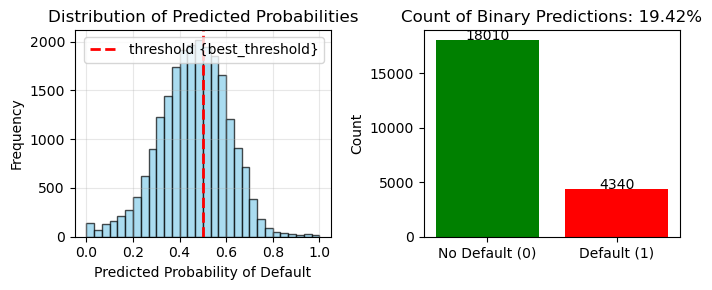

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 3))

# distribution of probabilities
ax1.hist(y_test_proba, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Predicted Probability of Default')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Predicted Probabilities')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='threshold {best_threshold}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Count of predictions
pred_counts = pd.Series(y_test_pred).value_counts()
ax2.bar(['No Default (0)', 'Default (1)'], pred_counts.values, color=['green', 'red'])
ax2.set_ylabel('Count')
ax2.set_title(f'Count of Binary Predictions: {pred_counts[1]/len(y_test_pred):.2%} (1)')
for i, v in enumerate(pred_counts.values):
    ax2.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

Observations:
- the distribution of predicted probabilities shows a centered around the threshold which means that 0 and 1 are not well separated, so already from here we can see that the model is not very good.
- 

In [45]:
# Classification metrics
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))



Confusion Matrix (Test):
[[17245  3891]
 [  765   449]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     21136
           1       0.10      0.37      0.16      1214

    accuracy                           0.79     22350
   macro avg       0.53      0.59      0.52     22350
weighted avg       0.91      0.79      0.84     22350



Meaning of the Confusion Matrix:
- 328 defaults correctly identified (True Positives).
- 886 defaults missed (False Negatives).
- 2373 good loans wrongly flagged as risky (False Positives).


For Class 0 (non-default):
- Precision = 0.96 → 96% of loans predicted “safe” are actually safe.
- Recall = 0.82 → model correctly captures 82% of all real safe loans.
- The model is reliable in spotting good payers.

For Class 1 (default):
- Precision = 0.10 → only 10% of predicted defaulters are real defaulters. It means there are many false alarms: the model overflags customers as risky.
- Recall = 0.37 → catches 37% of actual defaulters. It means that the model misses 63% of true defaulters (false negatives). We’re catching only 1 in 3 bad customers.
- Recall on defaults is critical if you want to catch as many bad customers as possible.
- F1 = 0.16 → weak performance on the minority class (defaults).

This means we reject many good customers (lost revenue) and still approve some bad ones (losses).

Accuracy:
- 79% of all predictions are correct.
- However, this is misleading because class 0 dominates (~95% of data).
- So predicting “everyone repays” could already give ~95% accuracy.

- Macro avg (averages metrics per class): treats classes equally.
    - 0.54–0.59 range → model struggles with minority class.

- Weighted avg (averages metrics weighted by class size).
    - 0.84 F1 → looks good, but driven mostly by majority class.

# AUC metrics

ROC-AUC
Training: 0.67
Validation: 0.66
Test: 0.66

PR-AUC
Test (Average Precision): 0.10


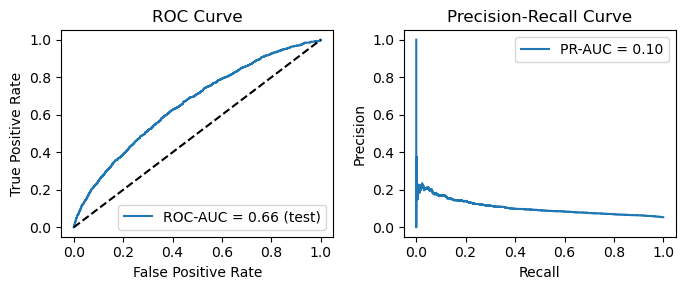

In [50]:
# AUC metrics 
print("ROC-AUC")
print(f"Training: {roc_auc_score(y_train, y_train_pred_proba):.2f}")
print(f"Validation: {roc_auc_score(y_val, y_val_proba):.2f}")
print(f"Test: {roc_auc_score(y_test, y_test_proba):.2f}")

print("\nPR-AUC")
print(f"Test (Average Precision): {average_precision_score(y_test, y_test_proba):.2f}")

# -- plot
f, (ax1,ax2) = plt.subplots(1,2, figsize=(7,3))
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax1.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_test_proba):.2f} (test)')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax2.plot(recall, precision, label=f'PR-AUC = {average_precision_score(y_test, y_test_proba):.2f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()
plt.tight_layout()
plt.show()

ROC-AUC:
- A value of 0.5 is like random guessing, 1 is perfect model.
- Having values 0.66-0.67, The model is better than random, but not very discriminative
- The values between train, validation, test are very similar -> no overfitting

PR-AUC (much more informative for inbalanced data):
- How good the model is at finding positives (defaults) among many negatives.
- The baseline PR-AUC = is roughly default rate (~5%). If ~5–10% of loans default, then a random model would have PR-AUC ≈ 0.05–0.10.
- So, in this case 0.105 means that the model performs slightly above random baseline, but not so much.

This matches the earlier observation in the confusion matrix: the model struggles to detect rare defaults.

# Check overfitting

In [47]:
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_set(y_true, y_proba, threshold):
    preds = (y_proba >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "precision": precision_score(y_true, preds),
        "recall": recall_score(y_true, preds),
        "f1": f1_score(y_true, preds)
    }

train_metrics = evaluate_set(y_train, y_train_pred_proba, best_threshold)
val_metrics = evaluate_set(y_val, y_val_proba, best_threshold)

print("Train metrics:", train_metrics)
print("Validation metrics:", val_metrics)


Train metrics: {'roc_auc': 0.6722410794436171, 'pr_auc': 0.10423867866512074, 'precision': 0.10700433493041296, 'recall': 0.3862201482294812, 'f1': 0.16757979990471653}
Validation metrics: {'roc_auc': 0.6575726884305859, 'pr_auc': 0.09759808872839912, 'precision': 0.09802158273381295, 'recall': 0.35914332784184516, 'f1': 0.15400918403391028}


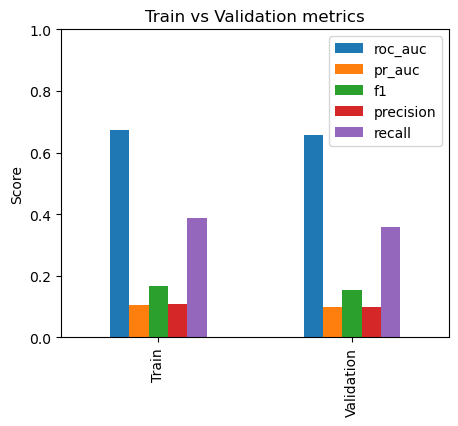

In [48]:
metrics_df = pd.DataFrame([train_metrics, val_metrics], index=["Train", "Validation"])
metrics_df[["roc_auc", "pr_auc", "f1", "precision", "recall"]].plot(kind="bar", figsize=(5,4))
plt.title("Train vs Validation metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


It seems to be similar between train and validation sets, so no overfitting detected.

# Next steps to improve

- Improve feature engineering: include categorical columns, which I have skipped now to simplify the ML production. Try defining new features, or remove some that are not useful.
- Use non-linear models: Try LightGBM or XGBoost as they capture interactions better.
- Check threshold tuning: Optimize for business cost (not 0.5 default).
- Data balance: Oversample defaults (SMOTE) or use more aggressive class weights.
- Check if temporal split is relevant here: ensure validation is future data to test stability.
- Add cross-validation with time folds (time-series CV).
- Use target encoding with K-fold out-of-fold scheme for merchant features.